# Problema 1) 

Considere o modelo (1) de previsão do consumo composto por defasagens de indicadores macroeconômicos típicos:

$$\Delta \ln C_t = \beta_0 + \sum_{k=1}^K \sum^L_{l=1} \beta_{k, l} F_{k, t-l} + \varepsilon_t + \theta_1 \varepsilon_{t-1} \tag{1}$$ 

em que $C_t$ é o nível de consumo no período $t$; $F_{k, t-l}$ é a defasagem de ordem $l$ da k-ésima variável macroeconômica; $\varepsilon_t$ é o termo de erro no período $t$.


Considere as seguintes medidas do consumo:

1.   Consumo de bens não-duráveis real per capita;
2.   Consumo de serviços real per capita;
3.   Consumo de bens duráveis real per capita;


Considere os seguintes fundamentos:

1.   Defasagens da medida de consumo em questão;
2.   Defasagens da renda pessoal disponível real per capita;
3.   Defasagens do retorno do S\&P500;
4.   Defasagens da taxa 3-Month Treasury Bill.


Após estimar o modelo (1), considere os seguintes modelos:


$$\Delta \ln C_t = \beta_0 + \sum_{k=1}^K \sum^L_{l=1} \beta_{k, l} F_{k, t-l} + \sum^L_{l=1} \gamma_{l} ICS_{t-l} + \varepsilon_t + \theta_1 \varepsilon_{t-1} \tag{2}$$ 
$$\Delta \ln C_t = \beta_0 + \sum_{k=1}^K \sum^L_{l=1} \beta_{k, l} F_{k, t-l} + \sum^L_{l=1} \gamma_{1,l} CI_{t-l} + \sum^L_{l=1} \gamma_{2,l} EI_{t-l} + \varepsilon_t + \theta_1 \varepsilon_{t-1} \tag{3}$$ 


em que são considerados os seguintes indices de confiança da Universidade de Michigan (http://www.sca.isr.umich.edu/tables.html):

1. Index of Consumer Sentiment (ICS);
2. Current Index (CI);
3. Expected Index (EI);

Estime os modelos (1), (2) e (3) para cada medida de consumo usando dados trimestrias

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.iolib.summary2 import summary_col

In [ ]:
# Importando os dados do Github
df_q  = pd.read_csv('https://raw.githubusercontent.com/lucasestrela/dec_consumo_poupanca/main/dados/dataset_trim.csv',
                    delimiter = ",", index_col=0
                    )


confianca  = pd.read_csv('https://raw.githubusercontent.com/lucasestrela/dec_consumo_poupanca/main/dados/indices_confianca.csv',
                    delimiter = ";", index_col=0
                    )[['ics', 'ci', 'ei', 'dpi_percapta', 'pop']]

# Ajustado o indice como data
df_q.index = pd.to_datetime(df_q.index)
confianca.index = pd.to_datetime(confianca.index, format="%d/%m/%Y")

# Juntando os dataframes
df = df_q.join(confianca)

# Tomando a diferença da disposable personal income per capita
df['dpi_pcapta_growth'] = np.log(df['dpi_percapta']/df['dpi_percapta'].shift(1))

# Medidas do consumo
df['c_pcapta_growth'] = df['c']/df['pop']
df['k_pcapta_growth'] = df['k']/df['pop']
df['s_pcapta_growth'] = df['s']/df['pop']



df['c_pcapta_growth'] = np.log(df['c_pcapta_growth']/df['c_pcapta_growth'].shift(1))
df['k_pcapta_growth'] = np.log(df['k_pcapta_growth']/df['k_pcapta_growth'].shift(1))
df['s_pcapta_growth'] = np.log(df['s_pcapta_growth']/df['s_pcapta_growth'].shift(1))

# Ajustando a frequencia do df
df = df.asfreq('Q', method='ffill')

In [ ]:
df['const'] = 1


################################################
#         Escolher Numero de defasagens        #
################################################
#                                              #
L = 1                                          #
#                                              #
################################################

v11 = [None] * L
v12 = [None] * L
v13 = [None] * L
v2 = [None] * L
v3 = [None] * L
v4 = [None] * L
v5 = [None] * L
v6 = [None] * L
v7 = [None] * L


for l_zinho in range(1, L+1):

    # Medidas de Consumo
    v11[l_zinho-1] = 'c_pcapta_growth.L' + str(l_zinho)
    v12[l_zinho-1] = 'k_pcapta_growth.L' + str(l_zinho)
    v13[l_zinho-1] = 's_pcapta_growth.L' + str(l_zinho)

    # Lags das Medidas de consumo
    df[v11[l_zinho-1]] = df['c_pcapta_growth'].shift(l_zinho)
    df[v12[l_zinho-1]] = df['k_pcapta_growth'].shift(l_zinho)
    df[v13[l_zinho-1]] = df['s_pcapta_growth'].shift(l_zinho)


# ------------------------------------------------------- #


    # Escolhendo as K-1 variáveis
    v2[l_zinho-1] = 'dpi_pcapta_growth.L' + str(l_zinho)
    v3[l_zinho-1] = 'sp500_ret_real.L' + str(l_zinho)
    v4[l_zinho-1] = 'TBill_ret_real.L' + str(l_zinho)

    # Lags das K-1 variaveis
    df[v2[l_zinho-1]] = df['dpi_pcapta_growth'].shift(l_zinho)
    df[v3[l_zinho-1]] = df['sp500_ret_real'].shift(l_zinho)
    df[v4[l_zinho-1]] = df['TBill_ret_real'].shift(l_zinho)


# ------------------------------------------------------- #


    # Variaveis de expectativas
    v5[l_zinho-1] = 'ics.L' + str(l_zinho)
    v6[l_zinho-1]  = 'ci.L' + str(l_zinho)
    v7[l_zinho-1]  = 'ei.L' + str(l_zinho)

    # Lag das expectativas
    df[v5[l_zinho-1]] = df['ics'].shift(l_zinho)
    df[v6[l_zinho-1]] = df['ci'].shift(l_zinho)
    df[v7[l_zinho-1]] = df['ei'].shift(l_zinho)



# Removendo os missings
dta_clean = df.dropna()

# Obtendo as covariadas
vars1 = [['const'], v11, v2, v3, v4]
vars2 = [['const'], v12, v2, v3, v4]
vars3 = [['const'], v13, v2, v3, v4]


concat_list1 = [j for i in vars1 for j in i]
concat_list2 = [j for i in vars2 for j in i]
concat_list3 = [j for i in vars3 for j in i]


In [ ]:
[ v5[0], v6[0], v7[0] ]

['ics.L1', 'ci.L1', 'ei.L1']

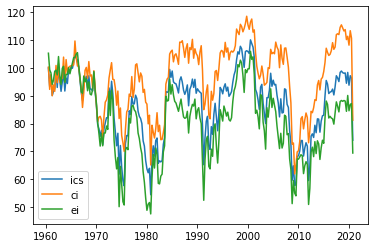

In [ ]:
plt.plot(dta_clean['ics.L1'], label = 'ics')
plt.plot(dta_clean['ci.L1'], label = 'ci')
plt.plot(dta_clean['ei.L1'], label = 'ei')
plt.legend()
plt.show()

$$\Delta \ln C_t = \beta_0 + \sum_{k=1}^K \sum^L_{l=1} \beta_{k, l} F_{k, t-l} + \varepsilon_t + \theta_1 \varepsilon_{t-1} \tag{1}$$ 


In [ ]:
n_dur = sm.tsa.statespace.SARIMAX(endog = dta_clean['c_pcapta_growth'],
                                exog = dta_clean[concat_list1], 
                                order=(0, 0, 1),
                                freq = 'Q')


serv_percapta = sm.tsa.statespace.SARIMAX(endog = dta_clean['k_pcapta_growth'],
                                exog = dta_clean[concat_list2], 
                                order=(0, 0, 1),
                                freq = 'Q')


dur_percapta = sm.tsa.statespace.SARIMAX(endog = dta_clean['s_pcapta_growth'],
                                exog = dta_clean[concat_list3], 
                                order=(0, 0, 1),
                                freq = 'Q')



res_n_dur         = n_dur.fit(disp = False, cov_type = 'robust_approx')
res_serv_percapta = serv_percapta.fit(disp=False, cov_type = 'robust_approx')
res_dur_percapta  = dur_percapta.fit(disp=False, cov_type = 'robust_approx')


sumario = summary_col([res_n_dur,res_serv_percapta,res_dur_percapta], stars=True, float_format='%0.2f',
            model_names=['Nao Duráveis \n(0)','Serviços \n(1)','Duráveis \n(2)'],
            info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}
            )

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
sumario.as_latex

<bound method Summary.as_latex of <class 'statsmodels.iolib.summary2.Summary'>
"""

                     Nao Duráveis  Serviços  Duráveis 
                          (0)         (1)       (2)   
------------------------------------------------------
TBill_ret_real.L1    0.03          0.19      -0.01    
                     (0.05)        (0.15)    (0.05)   
c_pcapta_growth.L1   0.06                             
                     (0.31)                           
const                0.00          0.00      0.00     
                     (0.00)        (0.00)    (0.00)   
dpi_pcapta_growth.L1 0.38***       0.98***   0.32***  
                     (0.09)        (0.20)    (0.12)   
k_pcapta_growth.L1                 0.27**             
                                   (0.12)             
ma.L1                -0.24         -0.47***  -0.03    
                     (0.27)        (0.10)    (0.55)   
s_pcapta_growth.L1                           -0.03    
                                    

$$\Delta \ln C_t = \beta_0 + \sum_{k=1}^K \sum^L_{l=1} \beta_{k, l} F_{k, t-l} + \sum^L_{l=1} \gamma_{l} ICS_{t-l} + \varepsilon_t + \theta_1 \varepsilon_{t-1} \tag{2}$$ 


In [ ]:
# Com ICS e sem CI e EI
vars1 = [['const'], v11, v2, v3, v4, v5]
vars2 = [['const'], v12, v2, v3, v4, v5]
vars3 = [['const'], v13, v2, v3, v4, v5]


concat_list1 = [j for i in vars1 for j in i]
concat_list2 = [j for i in vars2 for j in i]
concat_list3 = [j for i in vars3 for j in i]

In [ ]:
n_dur = sm.tsa.statespace.SARIMAX(endog = dta_clean['c_pcapta_growth'],
                                exog = dta_clean[concat_list1], 
                                order=(0, 0, 1),
                                freq = 'Q')


serv_percapta = sm.tsa.statespace.SARIMAX(endog = dta_clean['k_pcapta_growth'],
                                exog = dta_clean[concat_list2], 
                                order=(0, 0, 1),
                                freq = 'Q')


dur_percapta = sm.tsa.statespace.SARIMAX(endog = dta_clean['s_pcapta_growth'],
                                exog = dta_clean[concat_list3], 
                                order=(0, 0, 1),
                                freq = 'Q')



res_n_dur         = n_dur.fit(disp = False, cov_type = 'robust_approx')
res_serv_percapta = serv_percapta.fit(disp=False, cov_type = 'robust_approx')
res_dur_percapta  = dur_percapta.fit(disp=False, cov_type = 'robust_approx')


sumario = summary_col([res_n_dur,res_serv_percapta,res_dur_percapta], stars=True, float_format='%0.2f',
            model_names=['Nao Duráveis \n(0)','Serviços \n(1)','Duráveis \n(2)'],
            info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}
            )

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
sumario.as_latex

<bound method Summary.as_latex of <class 'statsmodels.iolib.summary2.Summary'>
"""

                     Nao Duráveis  Serviços  Duráveis 
                          (0)         (1)       (2)   
------------------------------------------------------
TBill_ret_real.L1    0.04          0.30      -0.01    
                     (0.05)        (0.22)    (0.05)   
c_pcapta_growth.L1   -0.26                            
                     (0.19)                           
const                -0.01**       -0.02     0.00     
                     (0.00)        (0.02)    (0.01)   
dpi_pcapta_growth.L1 0.33***       0.91***   0.32**   
                     (0.10)        (0.32)    (0.16)   
ics.L1               0.00***       0.00      -0.00    
                     (0.00)        (0.00)    (0.00)   
k_pcapta_growth.L1                 -0.19              
                                   (0.35)             
ma.L1                -0.03         -0.07     -0.03    
                     (0.17)        (


$$\Delta \ln C_t = \beta_0 + \sum_{k=1}^K \sum^L_{l=1} \beta_{k, l} F_{k, t-l} + \sum^L_{l=1} \gamma_{1,l} CI_{t-l} + \sum^L_{l=1} \gamma_{2,l} EI_{t-l} + \varepsilon_t + \theta_1 \varepsilon_{t-1} \tag{3}$$ 

In [ ]:
# Sem o ICS e com CI e EI
vars1 = [['const'], v11, v2, v3, v4, v6, v7]
vars2 = [['const'], v12, v2, v3, v4, v6, v7]
vars3 = [['const'], v13, v2, v3, v4, v6, v7]


concat_list1 = [j for i in vars1 for j in i]
concat_list2 = [j for i in vars2 for j in i]
concat_list3 = [j for i in vars3 for j in i]

In [ ]:
n_dur = sm.tsa.statespace.SARIMAX(endog = dta_clean['c_pcapta_growth'],
                                exog = dta_clean[concat_list1], 
                                order=(0, 0, 1),
                                freq = 'Q')


serv_percapta = sm.tsa.statespace.SARIMAX(endog = dta_clean['k_pcapta_growth'],
                                exog = dta_clean[concat_list2], 
                                order=(0, 0, 1),
                                freq = 'Q')


dur_percapta = sm.tsa.statespace.SARIMAX(endog = dta_clean['s_pcapta_growth'],
                                exog = dta_clean[concat_list3], 
                                order=(0, 0, 1),
                                freq = 'Q')



res_n_dur         = n_dur.fit(disp = False, cov_type = 'robust_approx')
res_serv_percapta = serv_percapta.fit(disp=False, cov_type = 'robust_approx')
res_dur_percapta  = dur_percapta.fit(disp=False, cov_type = 'robust_approx')


sumario = summary_col([res_n_dur,res_serv_percapta,res_dur_percapta], stars=True, float_format='%0.2f',
            model_names=['Nao Duráveis \n(0)','Serviços \n(1)','Duráveis \n(2)'],
            info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}
            )

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
sumario.as_latex

<bound method Summary.as_latex of <class 'statsmodels.iolib.summary2.Summary'>
"""

                     Nao Duráveis  Serviços  Duráveis 
                          (0)         (1)       (2)   
------------------------------------------------------
TBill_ret_real.L1    0.04          0.28      -0.02    
                     (0.05)        (0.22)    (0.05)   
c_pcapta_growth.L1   -0.25                            
                     (0.20)                           
ci.L1                0.00          -0.00     -0.00    
                     (0.00)        (0.00)    (0.00)   
const                -0.01**       -0.01     0.01     
                     (0.00)        (0.02)    (0.01)   
dpi_pcapta_growth.L1 0.33***       0.87***   0.29**   
                     (0.10)        (0.34)    (0.14)   
ei.L1                0.00          0.00      0.00**   
                     (0.00)        (0.00)    (0.00)   
k_pcapta_growth.L1                 -0.19              
                                   (